<a href="https://colab.research.google.com/github/0BVer/sch_AI/blob/main/dog_cat_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import
#python 3.7 version
#tensorflow 2.3 version
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import inception_v3

#tensorflow image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

#make callback to get valiable metrics
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import (f1_score, precision_score, recall_score)


#from collections import Counter
import itertools
import numpy as np 
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#make chart to visulaize
import matplotlib.pyplot as plt

#ignore error code, it`s not recommend at editing
import warnings
warnings.filterwarnings('ignore')

import os

In [ ]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

--2021-12-24 09:04:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   188MB/s    in 0.3s    

2021-12-24 09:04:06 (188 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2144840285026332215
xla_global_id: -1
]


In [ ]:
# 기본 경로
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련에 사용되는 고양이/개 이미지 경로
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_cats_dir)
print(train_dogs_dir)

# 테스트에 사용되는 고양이/개 이미지 경로
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_cats_dir)
print(validation_dogs_dir)

/tmp/cats_and_dogs_filtered/train/cats
/tmp/cats_and_dogs_filtered/train/dogs
/tmp/cats_and_dogs_filtered/validation/cats
/tmp/cats_and_dogs_filtered/validation/dogs


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(100, 100))
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                       batch_size=20,
                                                       class_mode  = 'binary',
                                                       target_size = (100, 100))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.python.keras.engine.input_layer import InputLayer
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet', input_shape=(100, 100, 3))
new_input = base_model.input

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(new_input, predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(Adam(lr=.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

epochs = 20
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = len(train_generator),
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    epochs = epochs
)

Epoch 1/20
100/100 [==============================] - 302s 3s/step - loss: 0.5477 - accuracy: 0.7085 - val_loss: 0.4786 - val_accuracy: 0.7700
Epoch 2/20
100/100 [==============================] - 281s 3s/step - loss: 0.3584 - accuracy: 0.8355 - val_loss: 0.4329 - val_accuracy: 0.7940
Epoch 3/20
100/100 [==============================] - 295s 3s/step - loss: 0.3013 - accuracy: 0.8655 - val_loss: 0.4145 - val_accuracy: 0.8030
Epoch 4/20
100/100 [==============================] - 279s 3s/step - loss: 0.2620 - accuracy: 0.8910 - val_loss: 0.3982 - val_accuracy: 0.8170
Epoch 5/20
100/100 [==============================] - 292s 3s/step - loss: 0.2353 - accuracy: 0.9060 - val_loss: 0.3940 - val_accuracy: 0.8230
Epoch 6/20
100/100 [==============================] - 278s 3s/step - loss: 0.2101 - accuracy: 0.9220 - val_loss: 0.4189 - val_accuracy: 0.8110
Epoch 7/20
100/100 [==============================] - 276s 3s/step - loss: 0.1908 - accuracy: 0.9355 - val_loss: 0.3932 - val_accuracy: 0.8240

In [ ]:
trial = 1
model.save_weights(datetime.today().strftime("%Y%m%d")+ '_weights_' +str(epochs) + '_' + str(trial) +'.h5')
model.save(datetime.today().strftime("%Y%m%d")+ '_model_'+ str(epochs) + '_' + str(trial) +'.h5')

Text(0.5, 0, 'Epoch')

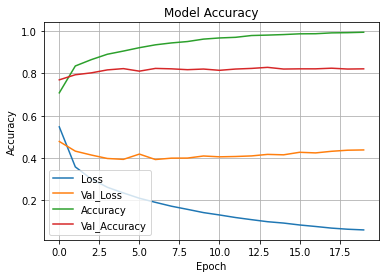

In [ ]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.legend()
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

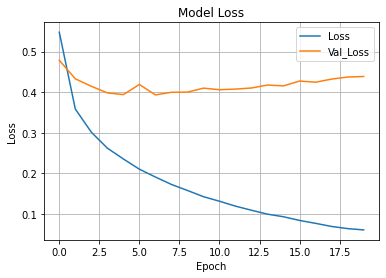

In [ ]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

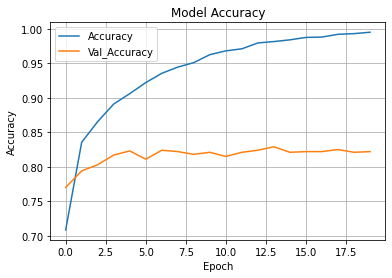

In [ ]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
scores = model.evaluate_generator(validation_generator, steps=5)

In [ ]:
print("-- Evaluate --")
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 83.00%


In [ ]:
base_model.trainable = True
#model.summary()

model.compile(Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 5
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/5
100/100 [==============================] - 307s 3s/step - loss: 0.0000e+00 - accuracy: 0.5675 - val_loss: 0.0000e+00 - val_accuracy: 0.5920
Epoch 2/5
100/100 [==============================] - 301s 3s/step - loss: 0.0000e+00 - accuracy: 0.5170 - val_loss: 0.0000e+00 - val_accuracy: 0.5090
Epoch 3/5
100/100 [==============================] - 303s 3s/step - loss: 0.0000e+00 - accuracy: 0.5185 - val_loss: 0.0000e+00 - val_accuracy: 0.5010
Epoch 4/5
100/100 [==============================] - 316s 3s/step - loss: 0.0000e+00 - accuracy: 0.5270 - val_loss: 0.0000e+00 - val_accuracy: 0.5050
Epoch 5/5
100/100 [==============================] - 316s 3s/step - loss: 0.0000e+00 - accuracy: 0.5960 - val_loss: 0.0000e+00 - val_accuracy: 0.5550


NameError: ignored

Text(0.5, 0, 'Epoch')

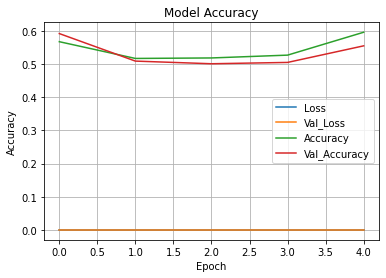

In [ ]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.legend()
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

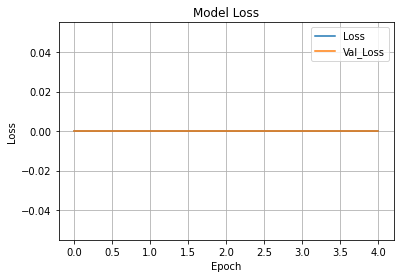

In [ ]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

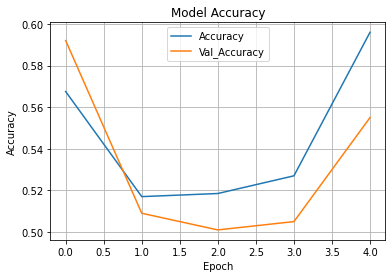

In [ ]:
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
scores = model.evaluate_generator(validation_generator, steps=5)

In [ ]:
print("-- Evaluate --")
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 53.00%
